# Логичтическая регрессия, метод опорных векторов, one-hot кодирование

### О задании

В этом задании вы изучите методы работы с категориальными переменными

In [6]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


__Задание 1.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

**(2 балла)**


Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [7]:
import pandas as pd
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [8]:
from sklearn.model_selection import train_test_split
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

=== КАЧ-ТВО МОДЕЛИ ===
Accuracy: 0.5886

Матрица ошибок:
[[31089 19054]
 [22086 27771]]

Классификация:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60     50143
           1       0.59      0.56      0.57     49857

    accuracy                           0.59    100000
   macro avg       0.59      0.59      0.59    100000
weighted avg       0.59      0.59      0.59    100000


10 самых главных признаков:
          feature  importance
4   ps_ind_05_cat    0.161318
27  ps_car_07_cat    0.111725
16  ps_ind_17_bin    0.108338
14      ps_ind_15    0.105177
20      ps_reg_03    0.094136
36      ps_car_15    0.091172
34      ps_car_13    0.076005
5   ps_ind_06_bin    0.063293
23  ps_car_03_cat    0.061812
6   ps_ind_07_bin    0.053200


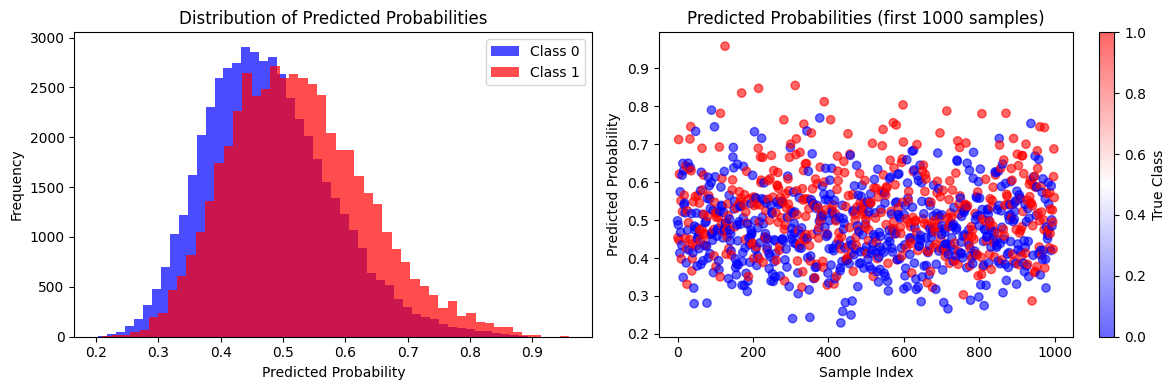

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(
    penalty='l2',      
    C=1.0,                  
    solver='liblinear',    
    random_state=42,
    max_iter=1000
)

log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=== КАЧ-ТВО МОДЕЛИ ===")
print(f"Accuracy: {accuracy:.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred))
print("\nКлассификация:")
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({
    'feature': data.columns,
    'importance': abs(log_reg.coef_[0])
}).sort_values('importance', ascending=False)

print("\n10 самых главных признаков:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Class 0', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Class 1', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_pred_proba[:1000])), y_pred_proba[:1000], c=y_test[:1000], cmap='bwr', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities (first 1000 samples)')
plt.colorbar(label='True Class')

plt.tight_layout()
plt.show()

Обучите логистическую регрессию с удобными для вас параметрами, примените регуляризацию, найдтие оптимум. Сделайте предсказание на тестовой части выборки. Замерьте качество.

__Выводы__ в свободной форме:

у нас стало поровну положительных и отрицательных примеров, для обучения модели это лучше

__Задание 2.__ Изучение влияния регуляризатора на процесс обучения

__(2 балла)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

=== БЕЗ регуляризации  ===
Iteration 0: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 10: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 20: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 30: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 40: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 50: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 60: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 70: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 80: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 90: Train Loss = 0.6691, Test Loss = 0.6695

=== С регуляризацией  ===
Iteration 0: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 10: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 20: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 30: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 40: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 50: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 60: Train Loss = 0.6691, Test Loss = 0.6695
Iteration 70: Train Loss = 0.6

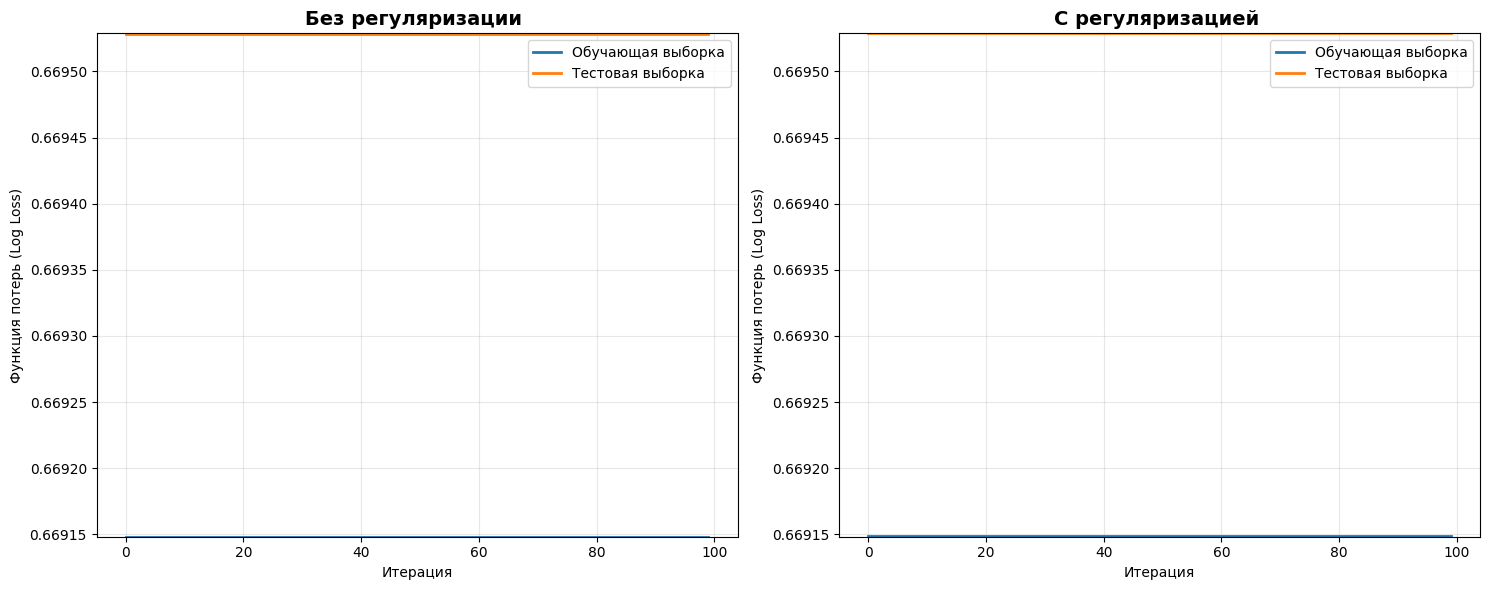

Без регуляризации :
  Финальная train loss: 0.6691
  Финальная test loss: 0.6695
  Разница (test - train): 0.0004

С регуляризацией :
  Финальная train loss: 0.6691
  Финальная test loss: 0.6695
  Разница (test - train): 0.0004
Регуляризация уменьшила переобучение в 1.00 раз


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def train_with_tracking(C_value, X_train, y_train, X_test, y_test, total_iterations=100):
    train_losses = []
    test_losses = []

    model = LogisticRegression(
        C=C_value,
        max_iter=1,  
        warm_start=True,  
        random_state=42,
        solver='liblinear',
        tol=1e-4  
    )
    
    model.fit(X_train, y_train)
    
    for i in range(total_iterations):
        model.fit(X_train, y_train)
        
        train_proba = model.predict_proba(X_train)
        test_proba = model.predict_proba(X_test)
        
        train_loss = log_loss(y_train, train_proba)
        test_loss = log_loss(y_test, test_proba)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if i % 10 == 0:
            print(f"Iteration {i}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    return train_losses, test_losses

print("=== БЕЗ регуляризации  ===")
train_losses_no_reg, test_losses_no_reg = train_with_tracking(
    C_value=10000,
    X_train=X_train_scaled,
    y_train=y_train, 
    X_test=X_test_scaled,
    y_test=y_test,
    total_iterations=100
)

print("\n=== С регуляризацией  ===")
train_losses_with_reg, test_losses_with_reg = train_with_tracking(
    C_value=0.1,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled, 
    y_test=y_test,
    total_iterations=100
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

all_losses = train_losses_no_reg + test_losses_no_reg + train_losses_with_reg + test_losses_with_reg
y_min = min(all_losses)
y_max = max(all_losses)

ax1.plot(train_losses_no_reg, label='Обучающая выборка', linewidth=2)
ax1.plot(test_losses_no_reg, label='Тестовая выборка', linewidth=2)
ax1.set_title('Без регуляризации ', fontsize=14, fontweight='bold')
ax1.set_xlabel('Итерация')
ax1.set_ylabel('Функция потерь (Log Loss)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([y_min, y_max])


ax2.plot(train_losses_with_reg, label='Обучающая выборка', linewidth=2)
ax2.plot(test_losses_with_reg, label='Тестовая выборка', linewidth=2)
ax2.set_title('С регуляризацией ', fontsize=14, fontweight='bold')
ax2.set_xlabel('Итерация')
ax2.set_ylabel('Функция потерь (Log Loss)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()



print(f"Без регуляризации :")
print(f"  Финальная train loss: {train_losses_no_reg[-1]:.4f}")
print(f"  Финальная test loss: {test_losses_no_reg[-1]:.4f}")
print(f"  Разница (test - train): {test_losses_no_reg[-1] - train_losses_no_reg[-1]:.4f}")

print(f"\nС регуляризацией :")
print(f"  Финальная train loss: {train_losses_with_reg[-1]:.4f}")
print(f"  Финальная test loss: {test_losses_with_reg[-1]:.4f}")
print(f"  Разница (test - train): {test_losses_with_reg[-1] - train_losses_with_reg[-1]:.4f}")

overfitting_no_reg = test_losses_no_reg[-1] - train_losses_no_reg[-1]
overfitting_with_reg = test_losses_with_reg[-1] - train_losses_with_reg[-1]


print(f"Регуляризация уменьшила переобучение в {overfitting_no_reg/overfitting_with_reg:.2f} раз")





__Выводы:__
регуляция не изменила время переобучения, хотя вроде должна была(видимо данные такие), и разры между Train loss и test loss не поменялся что тоже странно

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

__(3 балла)__

In [16]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 50000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 50000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

print("Исходная форма данных:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

def identify_categorical_features(df, threshold=0.05):
    categorical_features = []
    
    for column in df.columns:
        if df[column].dtype == 'object':
            categorical_features.append(column)
        elif len(df[column].unique()) / len(df) < threshold:
            categorical_features.append(column)
        elif df[column].nunique() < 40:
            categorical_features.append(column)
    
    return categorical_features

categorical_features = identify_categorical_features(X_train)
numerical_features = [col for col in X_train.columns if col not in categorical_features]

print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

for feature in categorical_features:
    unique_vals = X_train[feature].nunique()
    print(f"{feature}: {unique_vals} уникальных значений")

X_train_original = X_train.copy()
X_test_original = X_test.copy()

print("\n=== One-Hot кодирование ===")
start_time = time.time()

X_train_encoded = X_train[numerical_features].copy()
X_test_encoded = X_test[numerical_features].copy()

for feature in categorical_features:
    print(f"Кодируем признак: {feature}")
    
    top_categories = X_train[feature].value_counts().head(20).index
    X_train_temp = X_train[feature].where(X_train[feature].isin(top_categories), 'other')
    X_test_temp = X_test[feature].where(X_test[feature].isin(top_categories), 'other')
    
    dummies_train = pd.get_dummies(X_train_temp, prefix=feature, dtype=np.int8)
    X_train_encoded = pd.concat([X_train_encoded, dummies_train], axis=1)
    
    dummies_test = pd.get_dummies(X_test_temp, prefix=feature, dtype=np.int8)
    
    missing_cols = set(dummies_train.columns) - set(dummies_test.columns)
    for col in missing_cols:
        dummies_test[col] = 0
    
    dummies_test = dummies_test[dummies_train.columns]
    X_test_encoded = pd.concat([X_test_encoded, dummies_test], axis=1)

print(f"После One-Hot кодирования:")
print(f"X_train_encoded: {X_train_encoded.shape}")
print(f"X_test_encoded: {X_test_encoded.shape}")

X_train_encoded = X_train_encoded.fillna(0)
X_test_encoded = X_test_encoded.fillna(0)

scaler = StandardScaler()
X_train_scaled_encoded = scaler.fit_transform(X_train_encoded)
X_test_scaled_encoded = scaler.transform(X_test_encoded)

log_reg_encoded = LogisticRegression(
    C=0.1,
    max_iter=500,
    random_state=42,
    solver='liblinear'
)

log_reg_encoded.fit(X_train_scaled_encoded, y_train)
training_time_encoded = time.time() - start_time

y_pred_encoded = log_reg_encoded.predict(X_test_scaled_encoded)
y_pred_proba_encoded = log_reg_encoded.predict_proba(X_test_scaled_encoded)[:, 1]

accuracy_encoded = accuracy_score(y_test, y_pred_encoded)
roc_auc_encoded = roc_auc_score(y_test, y_pred_proba_encoded)
log_loss_encoded = log_loss(y_test, y_pred_proba_encoded)

print(f"Время обучения: {training_time_encoded:.2f} секунд")
print(f"Accuracy: {accuracy_encoded:.4f}")
print(f"ROC-AUC: {roc_auc_encoded:.4f}")
print(f"Log Loss: {log_loss_encoded:.4f}")

print("\n=== Mean-Target кодирование ===")
start_time_mte = time.time()

def mean_target_encoding_fast(X_train, X_test, y_train, categorical_features, numerical_features):
    X_train_encoded = X_train[numerical_features].copy()
    X_test_encoded = X_test[numerical_features].copy()
    overall_mean = y_train.mean()
    
    for feature in categorical_features:
        temp_df = pd.DataFrame({feature: X_train[feature], 'target': y_train})
        target_means = temp_df.groupby(feature)['target'].mean()
        target_map = target_means.to_dict()
        
        X_train_encoded[f'{feature}_mte'] = X_train[feature].map(target_map).fillna(overall_mean)
        X_test_encoded[f'{feature}_mte'] = X_test[feature].map(target_map).fillna(overall_mean)
    
    return X_train_encoded, X_test_encoded

X_train_mte, X_test_mte = mean_target_encoding_fast(X_train, X_test, y_train, categorical_features, numerical_features)

scaler_mte = StandardScaler()
X_train_scaled_mte = scaler_mte.fit_transform(X_train_mte)
X_test_scaled_mte = scaler_mte.transform(X_test_mte)

log_reg_mte = LogisticRegression(C=0.1, max_iter=500, random_state=42, solver='liblinear')
log_reg_mte.fit(X_train_scaled_mte, y_train)
time_mte = time.time() - start_time_mte

y_pred_proba_mte = log_reg_mte.predict_proba(X_test_scaled_mte)[:, 1]
accuracy_mte = accuracy_score(y_test, y_pred_proba_mte > 0.5)
roc_auc_mte = roc_auc_score(y_test, y_pred_proba_mte)

print(f"Mean-Target Encoding:")
print(f"  Время: {time_mte:.2f} сек, ROC-AUC: {roc_auc_mte:.4f}")

print("\nСРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print(f"{'Метод':<20} {'Признаков':<10} {'Время (с)':<10} {'Accuracy':<10} {'ROC-AUC':<10}")
print(f"{'One-Hot':<20} {X_train_encoded.shape[1]:<10} {training_time_encoded:<10.2f} {accuracy_encoded:<10.4f} {roc_auc_encoded:<10.4f}")
print(f"{'Mean-Target':<20} {X_train_mte.shape[1]:<10} {time_mte:<10.2f} {accuracy_mte:<10.4f} {roc_auc_mte:<10.4f}")

print(f"Сокращение размерности: {X_train_encoded.shape[1] / X_train_mte.shape[1]:.1f} раз")
print(f"Ускорение обучения: {training_time_encoded / time_mte:.1f} раз")
print(f"Разница в качестве: {roc_auc_mte - roc_auc_encoded:+.4f}")

Исходная форма данных:
X_train: (50000, 57)
X_test: (50000, 57)
Категориальные признаки (55): ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
ps_ind_01: 8 уникальных значений
ps_ind_02_cat

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

print("Исходная форма:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

def identify_categorical_features_fast(df, unique_threshold=50, freq_threshold=0.05):
    categorical_features = []
    
    for column in df.columns:
        n_unique = df[column].nunique()
        
        if (df[column].dtype == 'object' or 
            n_unique <= unique_threshold or 
            n_unique / len(df) <= freq_threshold):
            categorical_features.append(column)
    
    return categorical_features

categorical_features = identify_categorical_features_fast(X_train)
numerical_features = [col for col in X_train.columns if col not in categorical_features]

print(f"\nКатегориальные признаки ({len(categorical_features)}):")
for feature in categorical_features:
    unique_vals = X_train[feature].nunique()
    print(f"  {feature}: {unique_vals} уникальных значений")

# ОПТИМИЗИРОВАННОЕ One-Hot кодирование
print("\n=== One-Hot кодирование ===")

start_time_oh = time.time()

X_train_oh = X_train[numerical_features].copy()
X_test_oh = X_test[numerical_features].copy()

if categorical_features:
    dummies_train = pd.get_dummies(X_train[categorical_features], prefix_sep='_', dtype=np.int8)
    X_train_oh = pd.concat([X_train_oh, dummies_train], axis=1)
    
    dummies_test = pd.get_dummies(X_test[categorical_features], prefix_sep='_', dtype=np.int8)
    X_test_oh = dummies_test.reindex(columns=dummies_train.columns, fill_value=0)
    X_test_oh = pd.concat([X_test[numerical_features], X_test_oh], axis=1)


scaler_oh = StandardScaler()
X_train_scaled_oh = scaler_oh.fit_transform(X_train_oh)
X_test_scaled_oh = scaler_oh.transform(X_test_oh)

log_reg_oh = LogisticRegression(C=0.1, max_iter=500, random_state=42, solver='liblinear', verbose=0)
log_reg_oh.fit(X_train_scaled_oh, y_train)
time_oh = time.time() - start_time_oh

y_pred_proba_oh = log_reg_oh.predict_proba(X_test_scaled_oh)[:, 1]
accuracy_oh = accuracy_score(y_test, y_pred_proba_oh > 0.5)
roc_auc_oh = roc_auc_score(y_test, y_pred_proba_oh)

print(f"One-Hot кодирование:")
print(f"  Время: {time_oh:.2f} сек, ROC-AUC: {roc_auc_oh:.4f}")

print("\n=== Mean-Target кодирование===")

start_time_mte = time.time()

def mean_target_encoding_correct(X_train, X_test, y_train, categorical_features, numerical_features):

    X_train_encoded = X_train[numerical_features].copy()
    X_test_encoded = X_test[numerical_features].copy()

    overall_mean = y_train.mean()
    
    for feature in categorical_features:
        print(f"Кодируем признак: {feature}")
        
        temp_df = pd.DataFrame({
            feature: X_train[feature],
            'target': y_train
        })
        
        target_means = temp_df.groupby(feature)['target'].mean()
        target_map = target_means.to_dict()
        
        X_train_encoded[f'{feature}_mte'] = X_train[feature].map(target_map).fillna(overall_mean)
        X_test_encoded[f'{feature}_mte'] = X_test[feature].map(target_map).fillna(overall_mean)
    
    return X_train_encoded, X_test_encoded

X_train_mte, X_test_mte = mean_target_encoding_correct(X_train, X_test, y_train, categorical_features, numerical_features)

print(f"Размерность после Mean-Target: {X_train_mte.shape}")

print(f"Пропущенные значения в train: {X_train_mte.isnull().sum().sum()}")
print(f"Пропущенные значения в test: {X_test_mte.isnull().sum().sum()}")

scaler_mte = StandardScaler()
X_train_scaled_mte = scaler_mte.fit_transform(X_train_mte)
X_test_scaled_mte = scaler_mte.transform(X_test_mte)

log_reg_mte = LogisticRegression(C=0.1, max_iter=500, random_state=42, solver='liblinear', verbose=0)
log_reg_mte.fit(X_train_scaled_mte, y_train)
time_mte = time.time() - start_time_mte

y_pred_proba_mte = log_reg_mte.predict_proba(X_test_scaled_mte)[:, 1]
accuracy_mte = accuracy_score(y_test, y_pred_proba_mte > 0.5)
roc_auc_mte = roc_auc_score(y_test, y_pred_proba_mte)

print(f"Mean-Target Encoding:")
print(f"  Время: {time_mte:.2f} сек, ROC-AUC: {roc_auc_mte:.4f}")


print(f"{'Метод':<15} {'Признаков':<10} {'Время (с)':<10} {'Accuracy':<10} {'ROC-AUC':<10}")

print(f"{'One-Hot':<15} {X_train_oh.shape[1]:<10} {time_oh:<10.2f} {accuracy_oh:<10.4f} {roc_auc_oh:<10.4f}")
print(f"{'Mean-Target':<15} {X_train_mte.shape[1]:<10} {time_mte:<10.2f} {accuracy_mte:<10.4f} {roc_auc_mte:<10.4f}")


print(f"\nАНАЛИЗ:")
print(f"Сокращение размерности: {X_train_oh.shape[1] / X_train_mte.shape[1]:.1f} раз")
print(f"Ускорение обучения: {time_oh / time_mte:.1f} раз")
print(f"Разница в качестве: {roc_auc_mte - roc_auc_oh:+.4f}")


if not X_train_mte.empty:
    feature_importance = pd.DataFrame({
        'feature': X_train_mte.columns,
        'importance': abs(log_reg_mte.coef_[0])
    }).sort_values('importance', ascending=False)
    
    print(f"\nТоп-5 важных признаков (Mean-Target):")
    print(feature_importance.head(5))

Исходная форма данных:
X_train: (100000, 57), X_test: (100000, 57)

Категориальные признаки (56):
  ps_ind_01: 8 уникальных значений
  ps_ind_02_cat: 5 уникальных значений
  ps_ind_03: 12 уникальных значений
  ps_ind_04_cat: 3 уникальных значений
  ps_ind_05_cat: 8 уникальных значений
  ps_ind_06_bin: 2 уникальных значений
  ps_ind_07_bin: 2 уникальных значений
  ps_ind_08_bin: 2 уникальных значений
  ps_ind_09_bin: 2 уникальных значений
  ps_ind_10_bin: 2 уникальных значений
  ps_ind_11_bin: 2 уникальных значений
  ps_ind_12_bin: 2 уникальных значений
  ps_ind_13_bin: 2 уникальных значений
  ps_ind_14: 5 уникальных значений
  ps_ind_15: 14 уникальных значений
  ps_ind_16_bin: 2 уникальных значений
  ps_ind_17_bin: 2 уникальных значений
  ps_ind_18_bin: 2 уникальных значений
  ps_reg_01: 10 уникальных значений
  ps_reg_02: 19 уникальных значений
  ps_reg_03: 4401 уникальных значений
  ps_car_01_cat: 13 уникальных значений
  ps_car_02_cat: 2 уникальных значений
  ps_car_03_cat: 3 уникал

__Вывод:__
Mean-Target существенное быстрее по  времени обучения, а по данным не сильно влияет

    Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
    - вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
    - вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
    - внесение некоторого шума в посчитанные признаки (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков).

    __Задание 3.__ Реализуйте корректное вычисление счётчиков двумя из трех вышеперчисленных способов, сравните. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

    __(3 балла)__

Исходная форма данных:
X_train: (50000, 57), X_test: (50000, 57)
Категориальные признаки (55): ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

=== КФолд Mean-Target кодирование ===
КФолд 

ValueError: cannot reindex on an axis with duplicate labels